# Project Data and Decisions: Applied Analytics. Credit Risk Modelling.

### Authors: Clément BEAULIEU, Romain GUY, Luc PRIORETTI, Dylan PIERRE-FRANCOIS, Matthieu LALANNE

In [1]:
### Import packages

import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_score, classification_report, confusion_matrix, auc, RocCurveDisplay, accuracy_score, precision_recall_fscore_support
import xgboost as xgb

# Import Plotly
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# Data Preprocessing

## Data loading

In [2]:
### Upload the data in a Pandas Dataframe.

DATA_PATH = 'C:/Users/PC-HP/Desktop/Clement/credit_risk/data/credit_risk_dataset.csv'

data = pd.read_csv(DATA_PATH, header = 0, index_col = False)

In [3]:
# Print the dataframe.

data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
# Print the shape of the feature space and dtypes of features.

print('The shape of our features is:', data.shape)
data.dtypes

The shape of our features is: (32581, 12)


person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

## Data cleaning

In [5]:
# Check if null entries.

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
# Drop null entries.

data = data.dropna(axis=0)

print('The shape of our features is:', data.shape)

The shape of our features is: (28638, 12)


In [7]:
# Check for outliers.

pd.set_option('display.float_format', lambda x: '%.1f' % x)
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28638.0,28638.0,28638.0,28638.0,28638.0,28638.0,28638.0,28638.0
mean,27.7,66649.4,4.8,9656.5,11.0,0.2,0.2,5.8
std,6.3,62356.4,4.2,6329.7,3.2,0.4,0.1,4.0
min,20.0,4000.0,0.0,500.0,5.4,0.0,0.0,2.0
25%,23.0,39480.0,2.0,5000.0,7.9,0.0,0.1,3.0
50%,26.0,55956.0,4.0,8000.0,11.0,0.0,0.1,4.0
75%,30.0,80000.0,7.0,12500.0,13.5,0.0,0.2,8.0
max,144.0,6000000.0,123.0,35000.0,23.2,1.0,0.8,30.0


In [8]:
# Scatterplot matrix
fig = px.scatter_matrix(data, dimensions=
["person_age","person_income","person_emp_length","loan_amnt","loan_int_rate"],
labels={col:col.replace('_', ' ') for col in data.columns}, height=900, color="loan_status", color_continuous_scale=px.colors.diverging.Tropic)
fig.show()

In [9]:
# Remove obvious outliers.

data = data[data["person_age"]<=100]
data = data[data["person_emp_length"]<=100]
data = data[data["person_income"]<= 4000000]

# Scatterplot matrix
fig = px.scatter_matrix(data, dimensions=
["person_age","person_income","person_emp_length","loan_amnt","loan_int_rate"],
labels={col:col.replace('_', ' ') for col in data.columns}, height=900, color="loan_status", color_continuous_scale=px.colors.diverging.Tropic)
fig.show()

In [10]:
# Function to drop outliers (even if there are non numerical features).

def drop_numerical_outliers(df, z_thresh=3):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include=[np.number]).apply(lambda x: np.abs(stats.zscore(x)) < z_thresh).all(axis=1)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)

drop_numerical_outliers(data)

#data.info()

## Class proportions

In [11]:
# Class proportions.
loan_status_count = data.loan_status.value_counts()

print('Classes proportions:')
print('   * Class 0 (no loan default):', loan_status_count[0])
print('   * Class 1 (loan default):', loan_status_count[1])
print('   * Probability of Default:', round((loan_status_count[1] / (loan_status_count[0] + loan_status_count[1])), 2)*100, "%")

Classes proportions:
   * Class 0 (no loan default): 21280
   * Class 1 (loan default): 5634
   * Probability of Default: 21.0 %


Our dataset is imbalanced, which was previsble: 21% of loans with a credit default.

The Default Probability from the dataset will consists of a baseline wehave to improve through our ML models.

## Class Properties

In [12]:
# Box plot for Loan Grades

fig = px.box(data, x="loan_grade", y="loan_percent_income", color="loan_status",
color_discrete_sequence=px.colors.qualitative.Dark24,
labels={col:col.replace('_', ' ') for col in data.columns},
category_orders={"loan_grade":["A","B","C","D","E","F","G"]})
fig.update_layout(legend=dict(orientation="h", yanchor="bottom",
y=1.02, xanchor="right", x=1))
fig.show()

In [13]:
# Parallel category diagram

fig = px.parallel_categories(data, color_continuous_scale=px.colors.sequential.RdBu, color="loan_status",
dimensions=['person_home_ownership', 'loan_intent', "loan_grade", 'cb_person_default_on_file'], labels={col:col.replace('_', ' ') for col in data.columns})
fig.show()

## Categorical features encoding.

We encode categorical features. Loan Grade has an ordinal structure so we encode it through Ordinal Encoding. Other categorical features are encoded through One-Hot Encoding.

In [14]:
# Ordinal encoding of loan_grade.
ord_features = ['loan_grade']

encoder = OrdinalEncoder()
encoder.fit(data[ord_features])
data[ord_features] = encoder.transform(data[ord_features])

# One Hot Encoding of remaining categorical features, with dummy variables.
cat_features = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
data = pd.get_dummies(data, columns=cat_features,dtype=np.int64)

## Features and labels.

In [15]:
### Preparing the data.

X = data.drop(['loan_status'], axis = 1)
Y = data['loan_status']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

In [16]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', Y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', Y_test.shape)

Training Features Shape: (21531, 20)
Training Labels Shape: (21531,)
Testing Features Shape: (5383, 20)
Testing Labels Shape: (5383,)


# Model Selection.

We now proceed to the model selection. The models we consider in our work are: Logistic Regression, Gaussian Naive Bayes Classifier, SVM Classifier and Random Forest Classifier. We make a K-Fold Cross Validation to select the best model. Metrics used to select the model is the Recall.

## Models.

In [17]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Naive Bayes', GaussianNB()),
    ('SVM', SVC()),
    ('Random Forest', RandomForestClassifier(n_estimators=1000, criterion = 'entropy', random_state=42)),
    ('XGBoost', xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, eval_metric='logloss', use_label_encoder=False))
]

## Cross Validation for Model Selection.

We do want to maximize Recall for the model selection. Indeed, Recall measures the ability to predict correctly the Positives ie the default case, it is the ratio True Positive/(True Positive + False Negative). Therefore, maximizing Recall Score would minimize the False Negatives.

In [18]:
### Code for ROC-AUC graph printing.

def model_roc_curve(name, estimators, _X, _y, _cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)
    for i, (train, test) in enumerate(_cv.split(_X, _y)):
        clf = estimators[i]
        viz = RocCurveDisplay.from_estimator(
            clf,
            _X[test],
            _y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="ROC Curve for " + name,
    )
    ax.legend(loc="lower right")
    fig.patch.set_facecolor('white')
    plt.show()
    return mean_fpr, mean_tpr, mean_auc, std_auc

### Mean Roc Curve.

def mean_roc_curve(models, roc_dict):
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Mean ROC Curves",
    )

    for name,_ in models:
        mean_fpr, mean_tpr, mean_auc, std_auc = roc_dict[name][0],roc_dict[name][1],roc_dict[name][2],roc_dict[name][3]
        ax.plot(
            mean_fpr,
            mean_tpr,
            label="Mean ROC " + name + r" (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

    ax.legend(loc="lower right")
    plt.xlabel("False Positive Rate (Positive Label: 1)")
    plt.ylabel("True Positive Rate (Positive Label: 1)")
    fig.patch.set_facecolor('white')
    plt.show()    


### Main Cross Validation function.

Cross Validation - Logistic Regression :
   * fit time : 0.29 (+/- 0.42)
   * accuracy : 0.82 (+/- 0.02)
   * recall : 0.27 (+/- 0.21)
   * roc_auc : 0.79 (+/- 0.04)


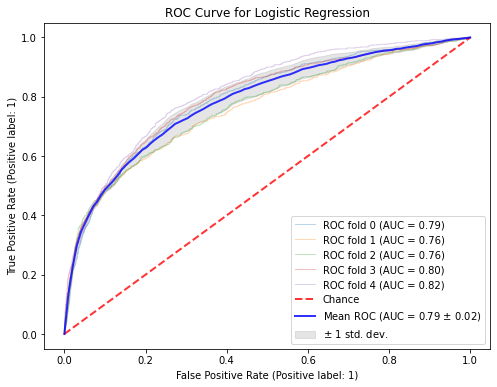

Cross Validation - Naive Bayes :
   * fit time : 0.05 (+/- 0.04)
   * accuracy : 0.83 (+/- 0.01)
   * recall : 0.43 (+/- 0.03)
   * roc_auc : 0.80 (+/- 0.01)


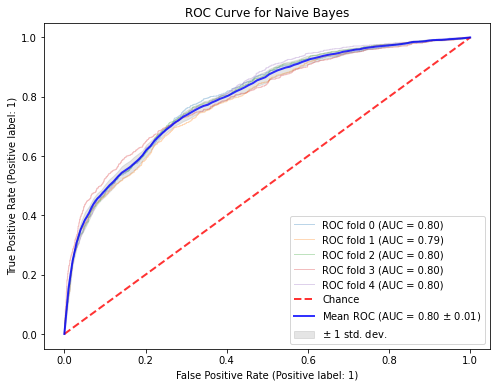

Cross Validation - SVM :
   * fit time : 22.51 (+/- 11.28)
   * accuracy : 0.80 (+/- 0.01)
   * recall : 0.06 (+/- 0.04)
   * roc_auc : 0.70 (+/- 0.03)


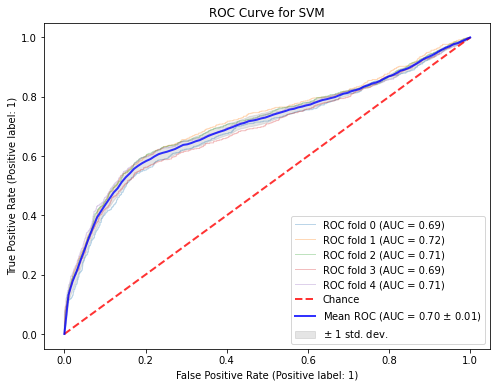

Cross Validation - Random Forest :
   * fit time : 32.59 (+/- 5.59)
   * accuracy : 0.93 (+/- 0.01)
   * recall : 0.70 (+/- 0.02)
   * roc_auc : 0.93 (+/- 0.01)


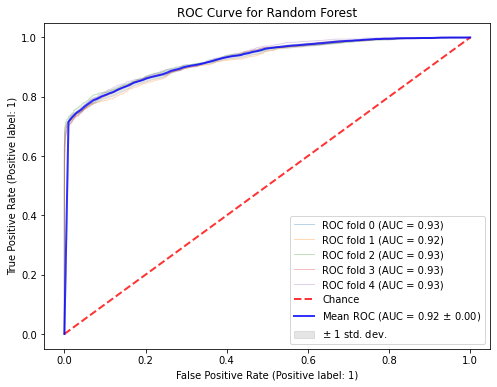

Cross Validation - XGBoost :
   * fit time : 18.87 (+/- 0.54)
   * accuracy : 0.94 (+/- 0.01)
   * recall : 0.73 (+/- 0.02)
   * roc_auc : 0.95 (+/- 0.01)


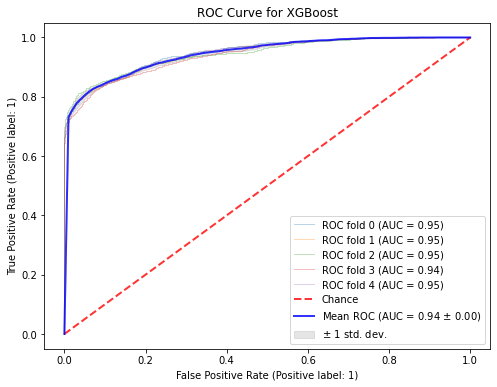

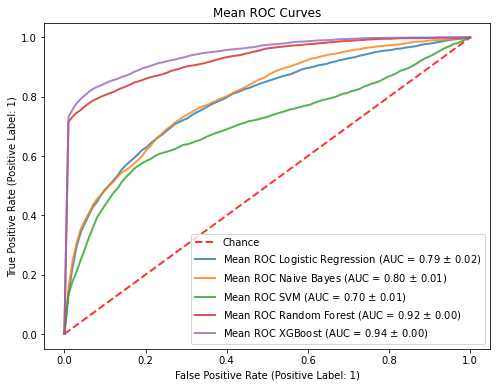

In [19]:
### Cross Validation function for a model with different Validation Scorings stored in a list. Roc curve parameter to print the ROC_AUC curve for validation.

def cross_val(name, model, _X, _y, _cv, _scoring, _roc_curve):
    X = np.array(_X)
    y = np.array(_y)
    clf = model
    scores = cross_validate(clf, X, y, cv = _cv, scoring = _scoring, return_train_score=True, return_estimator=True)
    print("Cross Validation - " + name +" :")
    print("   * fit time : %0.2f (+/- %0.2f)" % (scores['fit_time'].mean(), scores['fit_time'].std()*2))
    for scoring in _scoring:
        print("   * " + scoring + " : %0.2f (+/- %0.2f)" % (scores['test_'+ scoring].mean(), scores['test_'+ scoring].std()*2))
    if _roc_curve:
        return model_roc_curve(name, scores['estimator'], X, y, _cv)

### Model Evaluation with 5-Fold Cross Validation. Without Shuffle by default.

def validation(models, X_train, Y_train, cv=StratifiedKFold(n_splits=5), _scoring = ['accuracy', 'recall', 'roc_auc'], _roc_curve=True):
    roc_dict = {}
    for name, model in models:
        roc = cross_val(name, model, X_train, Y_train, cv, _scoring, _roc_curve)
        roc_dict[name]=roc
    if _roc_curve:
        mean_roc_curve(models, roc_dict)
        
validation(models, X_train, Y_train)

# Training models.

In [20]:
# Training function printing Mean Error, Accuracy, Classification Report and Confusion Matrix.

def training(name, model, X_train, y_train, X_test, y_test):
    clf = model
    clf.fit(X_train, y_train) # train the model on training data.
    predictions = clf.predict(X_test) # predictions on the test data.
    #preds_proba = clf.predict_proba(X_test)
    errors = abs(predictions - y_test) # calculate absolute errors.
    acc = clf.score(X_test, y_test) # accuracy.
    cm = confusion_matrix(y_test, predictions) # confusion matrix.
    cm1 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_diag = cm1.diagonal()
    class0_acc = cm_diag[0]
    class1_acc = cm_diag[1]
    
    print("*** Evaluation on Test Set ***")
    print('   * Mean Absolute Error of ' + name + ' :', round(np.mean(errors), 3)) # prints out the Mean Absolute Error (mae).
    print("   * Accuracy of " + name + ": %0.3f" % acc) # prints out total accuracy score.
    print("   * Accuracy/Recall on Class 0 : " + str(round(class0_acc, 3)))
    print("   * Accuracy/Recall on Class 1 : " + str(round(class1_acc, 3)))
    print("   * Default Probability (on Test Set) : " + str(round(1-precision_score(y_test, predictions, pos_label=0),4)))
    
    print(classification_report(y_test, predictions))
    
    print(pd.DataFrame(cm, 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive']))
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="ROC Curve (on Test Set) for "+name,
    )

    RocCurveDisplay.from_estimator(clf, X_test, Y_test, name="ROC Curve",
            alpha=0.8,
            lw=1,
            ax=ax)

    fig.patch.set_facecolor('white')
    plt.show()

    return clf

## Training of XGBoost algorithm and Testing.

The XGboost algorithm we train reduces the Default Probaility from 21.0% to 6.4% which is very satisfactory. It reduces the risk for both the lender and the borrower.

*** Evaluation on Test Set ***
   * Mean Absolute Error of XGBoost : 0.059
   * Accuracy of XGBoost: 0.941
   * Accuracy/Recall on Class 0 : 0.993
   * Accuracy/Recall on Class 1 : 0.742
   * Default Probability (on Test Set) : 0.0639
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4265
           1       0.97      0.74      0.84      1118

    accuracy                           0.94      5383
   macro avg       0.95      0.87      0.90      5383
weighted avg       0.94      0.94      0.94      5383

                 Predicted Negative  Predicted Positive
Actual Negative                4236                  29
Actual Positive                 289                 829


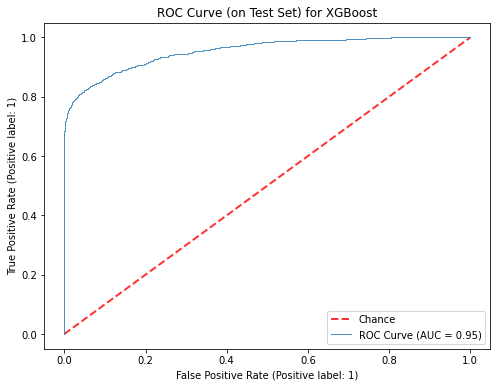

In [21]:
xgb_model = training('XGBoost', xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, eval_metric='logloss', use_label_encoder=False), X_train, Y_train, X_test, Y_test)

# Features importance.

In [22]:
# Get sorted features importance with F score.
feat_imp = xgb_model.get_booster().get_score(importance_type='weight')

import operator as op

sorted_feat_imp = dict(sorted(feat_imp.items(), key=op.itemgetter(1),reverse=True))
sorted_feat_imp

sorted_feat_imp


{'person_income': 7999.0,
 'loan_int_rate': 4896.0,
 'loan_amnt': 3530.0,
 'loan_percent_income': 2520.0,
 'person_emp_length': 2513.0,
 'person_age': 2498.0,
 'cb_person_cred_hist_length': 1574.0,
 'loan_grade': 1003.0,
 'loan_intent_MEDICAL': 568.0,
 'person_home_ownership_RENT': 563.0,
 'loan_intent_DEBTCONSOLIDATION': 435.0,
 'loan_intent_HOMEIMPROVEMENT': 434.0,
 'person_home_ownership_MORTGAGE': 432.0,
 'person_home_ownership_OWN': 370.0,
 'cb_person_default_on_file_N': 318.0,
 'loan_intent_EDUCATION': 302.0,
 'loan_intent_PERSONAL': 280.0,
 'loan_intent_VENTURE': 250.0,
 'person_home_ownership_OTHER': 10.0}

In [23]:
# Features which are not used.

set(X_train.columns) - set(feat_imp)

{'cb_person_default_on_file_Y'}

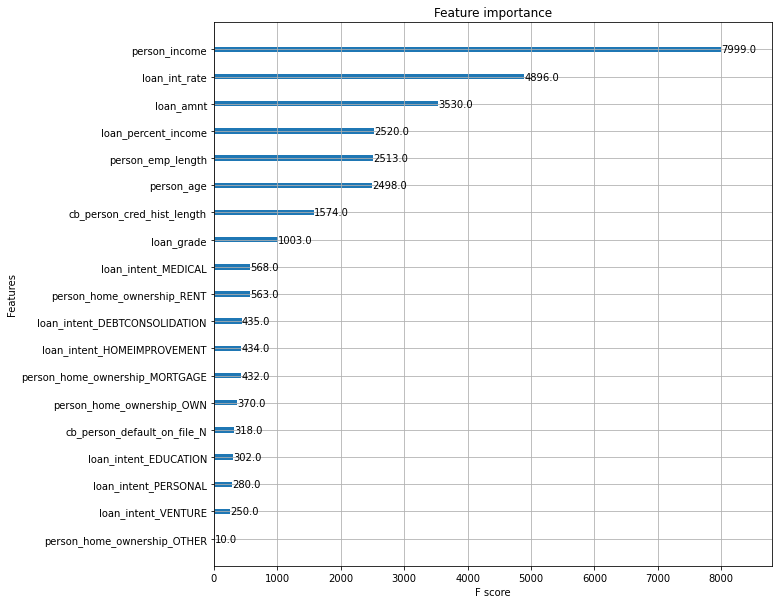

In [24]:
# Plots the feature importance graph.

fig, ax = plt.subplots(figsize=(10,10))
fig.patch.set_facecolor('white')
xgb.plot_importance(xgb_model,importance_type='weight', ax=ax)
plt.show()

# Probability Threshold.

We compute an optimal probability of default threshold. Above this threshold, the loan application should be rejected.

In [25]:
xgb_prob = pd.DataFrame(xgb_model.predict_proba(X_test)[:,1],columns = ['Default Probability'])
xgb_prob = pd.concat([xgb_prob, Y_test.reset_index(drop=True)],axis=1)
xgb_prob

,Default Probability,loan_status
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.1,0
...,...,...
5378,0.0,0
5379,0.1,0
5380,1.0,1
5381,0.0,0


In [26]:
# Checking 0.5 is the actual Threshold.

# Negative Class Predicted

neg = xgb_prob[xgb_prob['Default Probability'] <= 0.5].loan_status.value_counts()

print('Predicted Negative:')
print('   * Actual Negative (no loan default):', neg[0])
print('   * Actual Positive (loan default):', neg[1])

# Positive Class Predicted

pos = xgb_prob[xgb_prob['Default Probability'] > 0.5].loan_status.value_counts()

print('Predicted Positive:')
print('   * Actual Negative (no loan default):', pos[0])
print('   * Actual Positive (loan default):', pos[1])

Predicted Negative:
   * Actual Negative (no loan default): 4236
   * Actual Positive (loan default): 289
Predicted Positive:
   * Actual Negative (no loan default): 29
   * Actual Positive (loan default): 829


We now look for the optimal Probability threshold to maximize Recall.

In [27]:
thresh = np.linspace(0,1,101)
thresh

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [28]:
# Finding Optimal Threshold Function.

def opt_threshold(predict,thr =thresh, y_true = Y_test):
    data = predict.copy()
    
    def_recalls = []
    nondef_recalls = []
    accs =[]

    
    for threshold in thr:
        # predicted values for each threshold
        data['loan_status'] = data['Default Probability'].apply(lambda x: 1 if x > threshold else 0 )
        
        accs.append(accuracy_score(y_true, data['loan_status']))
        
        stats = precision_recall_fscore_support(y_true, data['loan_status'])
        
        def_recalls.append(stats[1][1])
        nondef_recalls.append(stats[1][0])
        
        
    return accs, def_recalls, nondef_recalls

In [29]:
import warnings
warnings.filterwarnings('ignore')

accs, def_recalls, nondef_recalls= opt_threshold(xgb_prob)

optim_threshold = accs.index(max(accs))

threshold = thresh[optim_threshold]

print("Optimal Probability threshold :", threshold)
print("Accuracy : ", round(accs[optim_threshold],3))
print("Recall for Positive Class (default): ", round(def_recalls[optim_threshold],3))

Optimal Probability threshold : 0.45
Accuracy :  0.942
Recall for Positive Class (default):  0.756


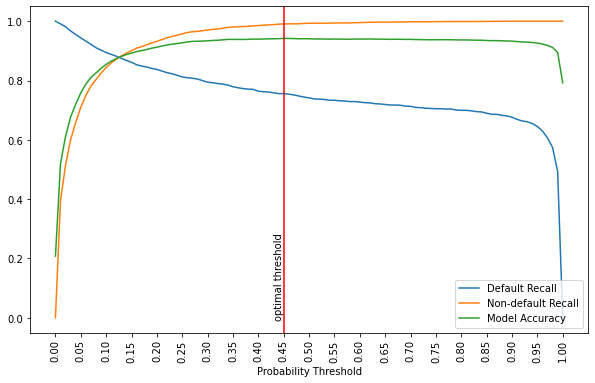

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.xticks(np.linspace(0,1,21), rotation = 'vertical')
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"], loc="lower right")
plt.axvline(x=threshold, color='red')
plt.text(threshold-0.02, 0,'optimal threshold',rotation=90)
fig.patch.set_facecolor('white')
plt.show()

In [31]:
# Computing

# Negative Class Predicted

neg = xgb_prob[xgb_prob['Default Probability'] <= threshold].loan_status.value_counts()

print('Predicted Negative:')
print('   * Actual Negative (no loan default):', neg[0])
print('   * Actual Positive (loan default):', neg[1])

# Positive Class Predicted

pos = xgb_prob[xgb_prob['Default Probability'] > threshold].loan_status.value_counts()

print('Predicted Positive:')
print('   * Actual Negative (no loan default):', pos[0])
print('   * Actual Positive (loan default):', pos[1])

# Default Probability

print("\nNew Default Probability : " + str(round(float(neg[1])/(float(neg[0])+neg[1])*100,2))+" %")

Predicted Negative:
   * Actual Negative (no loan default): 4226
   * Actual Positive (loan default): 273
Predicted Positive:
   * Actual Negative (no loan default): 39
   * Actual Positive (loan default): 845

New Default Probability : 6.07 %
